#Convolutional Neural Network for identifying 3 most commonly mistaken species of gulls in Poland - *Larus argentatus*, *Larus cachinnans* and *Larus michachellis*

<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/bazylip/gulls-ai-guide/blob/master/gulls_guide.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/bazylip/gulls-ai-guide/blob/master/gulls_guide.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [1]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

import matplotlib.pyplot as plt
import numpy as np
import random
import re
from PIL import Image, ImageOps, ImageFile
from io import BytesIO
from tqdm import tqdm
from bs4 import BeautifulSoup
from google.colab import files, drive
import requests
import collections

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0
drive.mount('/content/drive')

DOWNLOAD_FILES = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download images from [Gull Research website](http://www.gull-research.org/)

In [2]:
if DOWNLOAD_FILES:
  urls = ['http://www.gull-research.org/hg/hg1cy/', 'http://www.gull-research.org/hg/hg2cy/',
          'http://www.gull-research.org/hg/hg3cy/', 'http://www.gull-research.org/hg/hg4cy/',
          'http://www.gull-research.org/hg/hg5cy/']
  image_urls = collections.defaultdict(list)

  def list_files(url, ext='html'):
      page = requests.get(url).text
      soup = BeautifulSoup(page, 'html.parser')
      return [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]
    
  def get_all_image_urls(site):
      response = requests.get(site)

      soup = BeautifulSoup(response.text, 'html.parser')
      img_tags = soup.find_all('img')

      urls = [img['src'] for img in img_tags]
      image_urls = []
      for url in urls:
          filename = re.search(r'/([\w_-]+[.](jpg|png|JPG|PNG))$', url)
          if not filename:
              continue
          if 'http' not in url:
              # sometimes an image source can be relative 
              # if it is provide the base url which also happens 
              # to be the site variable atm.
              site_level_below = '/'.join(site.split('/')[:-2])
              url_with_no_dots = '/'.join(url.split('/')[1:]) 
              url = f"{site_level_below}/{url_with_no_dots}"
          image_urls.append(url)
      return image_urls

  for age, url in enumerate(urls):
    for site in list_files(url):
      urls_from_site = get_all_image_urls(site)
      
      if urls_from_site is not None:
        for image_url in urls_from_site:
          image_urls[age+1].append(image_url)



In [3]:
if DOWNLOAD_FILES:
  for age in image_urls.keys():
    print(f"Images for age {age}: {len(image_urls[age])}")

Download the images and turn them into np.array

In [10]:
size = (400, 400)

if DOWNLOAD_FILES:

  images_and_labels = []

  ImageFile.LOAD_TRUNCATED_IMAGES = True

  for age in image_urls.keys():
    for url in image_urls[age]:
      try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        square_size = max(img.size)

        img_square = ImageOps.fit(img, (square_size, square_size), Image.ANTIALIAS)
        img_resized = img_square.resize(size, Image.ANTIALIAS)

        img_array = np.asarray(img_resized)
        images_and_labels.append((img_array, age))
      except:
        pass


In [5]:
if DOWNLOAD_FILES:
  for tup in images_and_labels:
    if tup[0].shape != (400,400,3):
      images_and_labels.pop(images_and_labels.index(tup))

Now divide the images and labels into train set and test set

In [6]:
if DOWNLOAD_FILES:
  random.shuffle(images_and_labels)
  train_set_size = 1000

  train_images = np.asarray([tup[0] for tup in images_and_labels][:-train_set_size])
  train_labels = np.asarray([tup[1]-1 for tup in images_and_labels][:-train_set_size])

  test_images = np.asarray([tup[0] for tup in images_and_labels][-train_set_size:])
  test_labels = np.asarray([tup[1]-1 for tup in images_and_labels][-train_set_size:])

  np_arrays = [train_images, train_labels, test_images, test_labels]
  np_arrays_names = ["train_images", "train_labels", "test_images", "test_labels"]
  for np_array, np_array_name in zip(np_arrays, np_arrays_names):
    with open(f"/content/drive/My Drive/{np_array_name}.npy", "w+b") as f:
      np.save(f, np_array)
else:
  def load_binaries():
    file_names = ["train_images", "train_labels", "test_images", "test_labels"]
    nd_arrays = []

    for file_name in file_names:
      with open(f"/content/drive/My Drive/{file_name}.npy", "rb") as f:
        nd_arrays.append(np.load(f))

    return (nd_arrays[0], nd_arrays[1]), (nd_arrays[2], nd_arrays[3])

  (train_images, train_labels), (test_images, test_labels) = load_binaries()         


print(f"Length of training set: {len(train_images)}")
print(f"Length of test set: {len(test_images)}")

Length of training set: 6420
Length of test set: 1000


Let's see some example pictures from the dataset

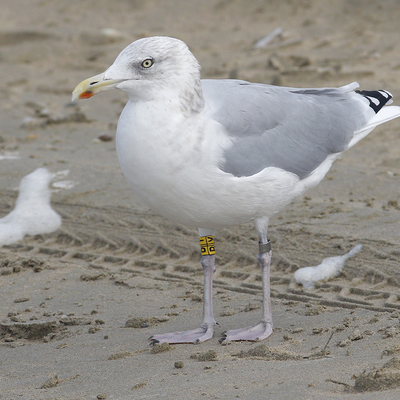

5


In [12]:
def numpy2pil(np_array):
    assert_msg = 'Input shall be a HxWx3 ndarray'
    assert isinstance(np_array, np.ndarray), assert_msg
    assert len(np_array.shape) == 3, assert_msg
    assert np_array.shape[2] == 3, assert_msg

    img = Image.fromarray(np_array, 'RGB')
    return img

display(numpy2pil(train_images[1]))
print(train_labels[1]+1)

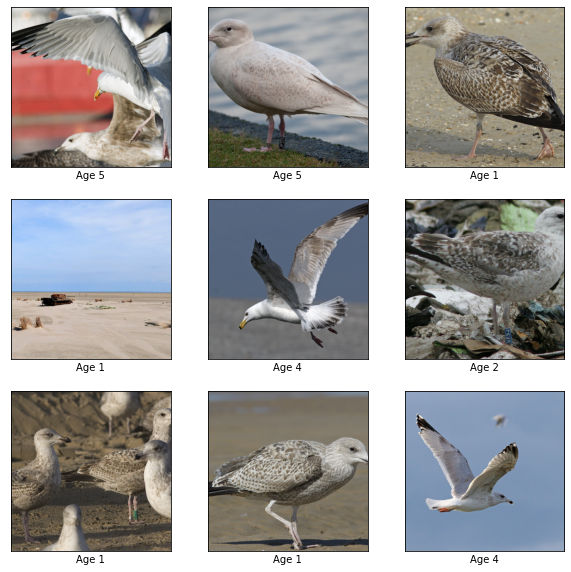

In [13]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(4000,9)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(f"Age {train_labels[image_ind]+1}")

Let's get to work and build the network

In [14]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(size[0], size[1], 3)),

        tf.keras.layers.Conv2D(filters=24, kernel_size=3, activation='relu'), 
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=36, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(5, activation=tf.nn.sigmoid)
    ])
    
    return cnn_model
  
cnn_model = build_cnn_model()

cnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 400, 400, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 398, 398, 24)      672       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 24)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 197, 197, 36)      7812      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 36)        0         
_________________________________________________________________
flatten (Flatten)            (None, 345744)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

Train the model

In [15]:
BATCH_SIZE = 64
EPOCHS = 5

cnn_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
101/101 [==============================] - 15s 149ms/step - loss: 1.6067 - accuracy: 0.2431
Epoch 2/5
101/101 [==============================] - 15s 148ms/step - loss: 1.5746 - accuracy: 0.2889
Epoch 3/5
101/101 [==============================] - 15s 148ms/step - loss: 1.5693 - accuracy: 0.2724
Epoch 4/5
101/101 [==============================] - 15s 148ms/step - loss: 1.5753 - accuracy: 0.2741
Epoch 5/5
101/101 [==============================] - 15s 150ms/step - loss: 1.5588 - accuracy: 0.2838


Check accuracy

In [16]:
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

32/32 [==============================] - 1s 29ms/step - loss: 1.5956 - accuracy: 0.2470
Test accuracy: 0.24699999392032623


In [18]:
predictions = cnn_model.predict(test_images)

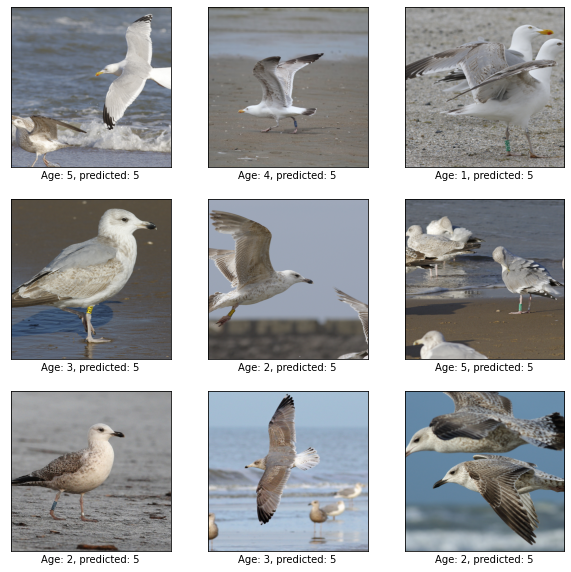

In [21]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(1000,9)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(test_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(f"Age: {test_labels[image_ind]+1}, predicted: {predictions[image_ind].argmax()+1}")